# Aprendizaje Automático


El objetivo de este práctico es afianzar los conocimientos adquiridos hasta este momento, haciendo un proceso de re-análisis de los datos para encarar desde distintas perspectivas (selección de features, redefinición de clases y subclases) para conseguir nuevos resultados sobre los modelos ya trabajados, añadiendo ensemble learning al análisis.

La idea es aprender a iterar en el proceso de ciencia de datos, no quedandonos con los resultados obtenidos del primer proceso realizado.

# Enunciado del práctico

Se les da la libertad de hacer los análisis que consideren necesarios en base a lo ya aprendido, encarando el problema desde distintos puntos de vista sobre todo en el proceso de los datos. para generar perspectivas diferentes que amplíen desde la investigación los resultados ya obtenidos.

Generar un informe del enfoque que se tomó y cuales son las conclusiones a las que se arribó.

Se pide también que sumen aquellos algoritmos en la medida de lo posible (por la cantidad de datos) que se aprendieron en esta materia.



In [1]:
import sys
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
import string
import collections
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from wordcloud import WordCloud

In [2]:
# Se verfica entorno de ejecución
in_colab = "google.colab" in sys.modules

if in_colab:
    from google.colab import drive

    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/My Drive/Diplo2020 Mentoria/"
else:
    BASE_DIR = "../"

# Archivos a importar

In [3]:
def txt_to_text(path):
    filepath = open(path, encoding='utf-8')
    text = filepath.read()
    filepath.close()
    return text

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = dirName + '/' + entry
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [5]:
train_data_dir = BASE_DIR + "Datos/Infoleg"

In [6]:
listOfFile = getListOfFiles(train_data_dir)
print('Cantidad de archivos a importar:', len(listOfFile))    

Cantidad de archivos a importar: 2500


In [7]:
corpus = []
i = 0
for file in listOfFile:
    if file.endswith(".txt"):
        corpus.append([i, file, txt_to_text(file)])
        i = i+1

In [8]:
df_corpus = pandas.DataFrame(corpus,columns=['ID','FILE','TEXTO'])
df_corpus.head()

,ID,FILE,TEXTO
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...


# Analizamos una frase de un documento

Analizamos el primer documento para simplificar las pruebas en la limpiaza de datos.

In [9]:
texto = df_corpus[0:1].TEXTO[0]
print(df_corpus[0:1].FILE[0])
print(texto)

../Datos/Infoleg/100016.txt
ACUERDOS
Ley 25.939
Apruébase el Acuerdo Sobre Cooperación Minera suscripto en Caracas el 12 de julio de 2000 con la República Bolivariana de Venezuela. Elaboración de programas de Cooperación Científico-Técnica y de Acción. Solución de controversias.
Sancionada: Septiembre 22 de 2004
Promulgada de Hecho: Octubre 18 de 2004
El Senado y Cámara de Diputados de la Nación Argentina reunidos en Congreso, etc. sancionan con fuerza de Ley:
ARTICULO 1º — Apruébase el ACUERDO SOBRE COOPERACION MINERA ENTRE LA REPUBLICA ARGENTINA Y LA REPUBLICA BOLIVARIANA DE VENEZUELA, suscripto en Caracas —REPUBLICA BOLIVARIANA DE VENEZUELA— el 12 de julio de 2000, que consta de TRECE (13) artículos, cuya fotocopia autenticada forma parte de la presente ley.
ARTICULO 2º — Comuníquese al Poder Ejecutivo nacional.
DADA EN LA SALA DE SESIONES DEL CONGRESO ARGENTINO, EN BUENOS AIRES, A LOS VEINTIDOS DIAS DEL MES DE SEPTIEMBRE DEL AÑO DOS MIL CUATRO.
— REGISTRADO BAJO EL Nº 25.939 —
EDUA

Lo primero que tenemos que hacer es dividir el corpus en *tokens*. 

Si utilizamos la función *split()* no obtendremos una división con sentido lingüístico, ya que por ejemplo, no separa los signos de puntuación: *castellano,* ó *auténtico.*

Para evitar este inconveniente utilizamos la librería NLTK. La función por defecto es *nltk.word_tokenize()*, pero nosotros utilizamos *nltk.tokenize.toktok.ToktokTokenizer()*, ya que se obtienen mejores resultados con la lengua española (https://github.com/nltk/nltk/issues/1558)

Tomemos como ejemplo una parte del texto:

In [10]:
texto = "Caracas —REPUBLICA BOLIVARIANA DE VENEZUELA— el 12 de julio de 2000, — REGISTRADO BAJO EL Nº 25.939 — EDUARDO O. CAMAÑO. — MARCELO A. GUINLE. — Eduardo D. Rollano. — Juan J. Canals."
print(texto)

Caracas —REPUBLICA BOLIVARIANA DE VENEZUELA— el 12 de julio de 2000, — REGISTRADO BAJO EL Nº 25.939 — EDUARDO O. CAMAÑO. — MARCELO A. GUINLE. — Eduardo D. Rollano. — Juan J. Canals.


Utilizando *word_tokenize*

In [11]:
wt_tokens = [word for word in nltk.tokenize.word_tokenize(texto)]
print('Cantidad de tokens:', len(wt_tokens))
print(wt_tokens)

Cantidad de tokens: 38
['Caracas', '—REPUBLICA', 'BOLIVARIANA', 'DE', 'VENEZUELA—', 'el', '12', 'de', 'julio', 'de', '2000', ',', '—', 'REGISTRADO', 'BAJO', 'EL', 'Nº', '25.939', '—', 'EDUARDO', 'O.', 'CAMAÑO', '.', '—', 'MARCELO', 'A.', 'GUINLE', '.', '—', 'Eduardo', 'D.', 'Rollano', '.', '—', 'Juan', 'J.', 'Canals', '.']


Utilizando *TokTokTokenizer*

In [12]:
tt_tokens = ToktokTokenizer().tokenize(texto)
print('Cantidad de tokens:', len(tt_tokens))
print(tt_tokens)

Cantidad de tokens: 37
['Caracas', '—', 'REPUBLICA', 'BOLIVARIANA', 'DE', 'VENEZUELA', '—', 'el', '12', 'de', 'julio', 'de', '2000', ',', '—', 'REGISTRADO', 'BAJO', 'EL', 'Nº', '25.939', '—', 'EDUARDO', 'O.', 'CAMAÑO.', '—', 'MARCELO', 'A.', 'GUINLE.', '—', 'Eduardo', 'D.', 'Rollano.', '—', 'Juan', 'J.', 'Canals', '.']


Vemos que separó correctamente el signo *—* de *REPUBLICA* y *VENEZUELA*. Además separó el punto final de la oración, pero no los puntos de las demás palabras, como por ejemplo *GUINLE.*

In [13]:
tokens = ToktokTokenizer().tokenize(texto.lower())
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 37
['caracas', '—', 'republica', 'bolivariana', 'de', 'venezuela', '—', 'el', '12', 'de', 'julio', 'de', '2000', ',', '—', 'registrado', 'bajo', 'el', 'nº', '25.939', '—', 'eduardo', 'o.', 'camaño.', '—', 'marcelo', 'a.', 'guinle.', '—', 'eduardo', 'd.', 'rollano.', '—', 'juan', 'j.', 'canals', '.']


Para eliminar los signos de puntuación habíamos utilizado la función nltk.tokenize.punkt.PunktToken(token).is_non_punct. De acuerdo a la documentación (https://www.nltk.org/_modules/nltk/tokenize/punkt.html) la propiedad is_non_punct devuelve true si el token es un número o caracter alfanumérico.
La función utiliza la siguiente expresión regular: *[^\W\d]*

Encontramos mejor resultando utilizando *string.punctuation* y agregando el símbolo **—**, para luego seguir aplicando otros filtros.

In [14]:
print(string.punctuation, '—')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ —


In [15]:
signos_puntuacion = string.punctuation + '—'
tokens = list(filter(lambda token: token not in signos_puntuacion, tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 28
['caracas', 'republica', 'bolivariana', 'de', 'venezuela', 'el', '12', 'de', 'julio', 'de', '2000', 'registrado', 'bajo', 'el', 'nº', '25.939', 'eduardo', 'o.', 'camaño.', 'marcelo', 'a.', 'guinle.', 'eduardo', 'd.', 'rollano.', 'juan', 'j.', 'canals']


Tenemos que eliminar los tokens que:
* son signos y los que están incluidos en el token
* son solo números

In [16]:
# eliminar la puntuación de cada palabra
tokens = [re.sub('[%s]' % re.escape(signos_puntuacion), '', token) for token in tokens]
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 28
['caracas', 'republica', 'bolivariana', 'de', 'venezuela', 'el', '12', 'de', 'julio', 'de', '2000', 'registrado', 'bajo', 'el', 'nº', '25939', 'eduardo', 'o', 'camaño', 'marcelo', 'a', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canals']


In [17]:
# eliminar los números
tokens = list(filter(lambda token: token.isalpha(), tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 25
['caracas', 'republica', 'bolivariana', 'de', 'venezuela', 'el', 'de', 'julio', 'de', 'registrado', 'bajo', 'el', 'nº', 'eduardo', 'o', 'camaño', 'marcelo', 'a', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canals']


Eliminamos los stopwords, usando el de la librería NLTK

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jperezv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stop_words = nltk.corpus.stopwords.words('spanish')

In [20]:
tokens = list(filter(lambda token: token not in stop_words, tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 18
['caracas', 'republica', 'bolivariana', 'venezuela', 'julio', 'registrado', 'bajo', 'nº', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canals']


Lemmatizamos

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jperezv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokens = list(lemmatizer.lemmatize(token) for token in tokens)
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 18
['caracas', 'republica', 'bolivariana', 'venezuela', 'julio', 'registrado', 'bajo', 'nº', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canal']


Corregimos errores de ortografía: republica (sin acento)


In [23]:
dic_Errores = {'republica':'república'}
for i in range(len(tokens)):    
    for key in dic_Errores:
        if tokens[i] == key:
            tokens[i] = dic_Errores[key]
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 18
['caracas', 'república', 'bolivariana', 'venezuela', 'julio', 'registrado', 'bajo', 'nº', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'd', 'rollano', 'juan', 'j', 'canal']


Por último eliminamos los tokens que tienen menos de 3 caracteres ya que no representan palabras significativas

In [24]:
# eliminar los tokens de un solo caracter
tokens = list(filter(lambda token: len(token) > 3, tokens))
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 15
['caracas', 'república', 'bolivariana', 'venezuela', 'julio', 'registrado', 'bajo', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'rollano', 'juan', 'canal']


# Función de normalización

Unificamos todo en una función

In [25]:
def normalize_texto(texto):
    # Tokenización
    tokens = ToktokTokenizer().tokenize(texto)

    # Paso a minúscula
    tokens = [word.lower() for word in tokens]

    # Eliminamos símbolos de puntuación
    signos_puntuacion = string.punctuation + '—'
    tokens = list(filter(lambda token: token not in signos_puntuacion, tokens))

    # eliminar la puntuación de cada palabra
    tokens = [re.sub('[%s]' % re.escape(signos_puntuacion), '', token) for token in tokens]
    
    # eliminar los números
    tokens = list(filter(lambda token: token.isalpha(), tokens))

    # Eliminamos stopwords
    tokens = list(filter(lambda token: token not in stop_words, tokens)) 

    # Corregir palabras con errores de ortografía: republica (sin acento)
    dic_Errores = {'republica':'república'}
    for i in range(len(tokens)):    
        for key in dic_Errores:
            if tokens[i] == key:
                tokens[i] = dic_Errores[key]

    # Lemmatización
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # eliminar los tokens de menos de 3 caracteres
    tokens = list(filter(lambda token: len(token) > 3, tokens))

    return ' '.join(tokens)


Analizando el documento completo

In [26]:
texto = normalize_texto(df_corpus[0:1].TEXTO[0])
tokens = texto.split()
print('Cantidad de tokens:', len(tokens))
print(tokens)

Cantidad de tokens: 605
['acuerdos', 'apruébase', 'acuerdo', 'cooperación', 'minera', 'suscripto', 'caracas', 'julio', 'república', 'bolivariana', 'venezuela', 'elaboración', 'programas', 'cooperación', 'científicotécnica', 'acción', 'solución', 'controversias', 'sancionada', 'septiembre', 'promulgada', 'hecho', 'octubre', 'senado', 'cámara', 'diputados', 'nación', 'argentina', 'reunidos', 'congreso', 'sancionan', 'fuerza', 'articulo', 'apruébase', 'acuerdo', 'cooperacion', 'minera', 'república', 'argentina', 'república', 'bolivariana', 'venezuela', 'suscripto', 'caracas', 'república', 'bolivariana', 'venezuela', 'julio', 'consta', 'trece', 'artículos', 'cuya', 'fotocopia', 'autenticada', 'forma', 'parte', 'presente', 'articulo', 'comuníquese', 'poder', 'ejecutivo', 'nacional', 'dada', 'sala', 'sesiones', 'congreso', 'argentino', 'buenos', 'aire', 'veintidos', 'septiembre', 'cuatro', 'registrado', 'bajo', 'eduardo', 'camaño', 'marcelo', 'guinle', 'eduardo', 'rollano', 'juan', 'canal', 

Vemos las palabras más frecuentesen el documento

In [27]:
dic_tokens = collections.Counter(tokens)
df_tokens = pandas.DataFrame(dic_tokens.items(), columns=['Token', 'Frecuencia']).sort_values(by="Frecuencia", ascending=False)

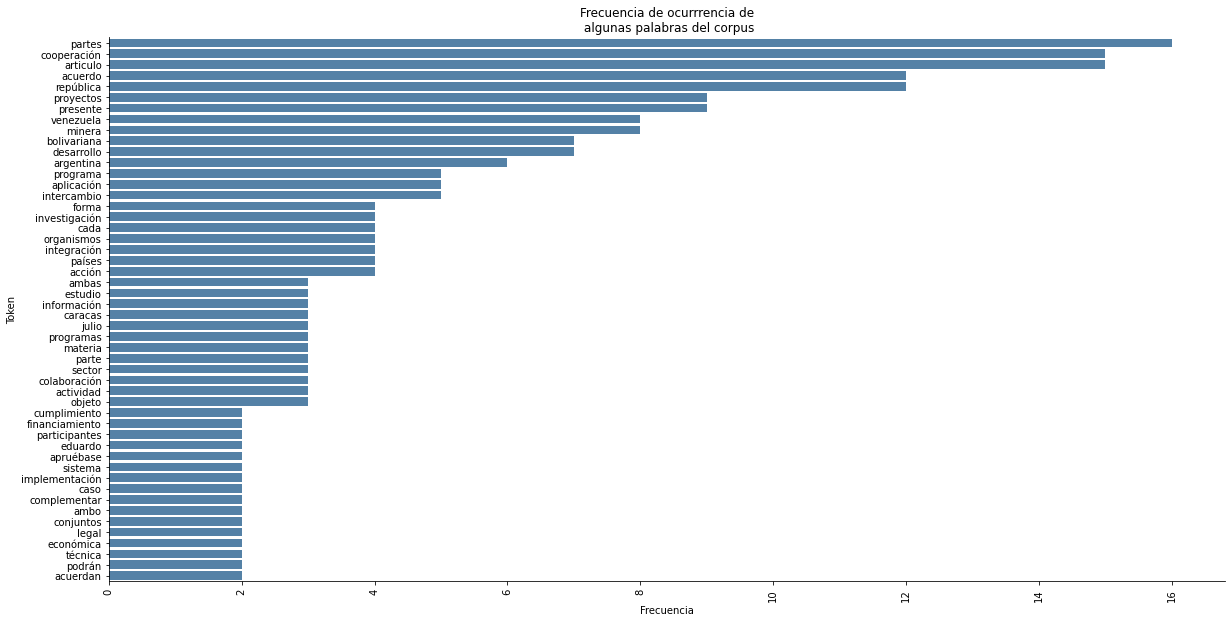

In [28]:
plt.figure(figsize=(20,10))
seaborn.barplot(y=df_tokens[:50].Token, x=df_tokens[:50].Frecuencia, color='steelblue')
plt.title('Frecuencia de ocurrrencia de\n algunas palabras del corpus')
plt.xticks(rotation=90)
seaborn.despine()

Graficamos lo mismo en una nube de palabras

In [29]:
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

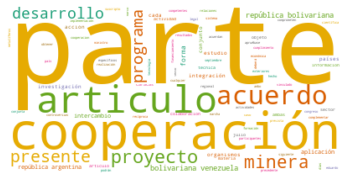

In [30]:
wc.generate(texto)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Las palabra que más se repiten, *parte* y *articulo*, no me dicen nada del documento. Pero hay otras con menor frecuencia, *acuerdo, cooperación, minera* que sí le dan sentido al documento, es un **acuerdo de cooperación minera**.

Ampliaremos el listado de stop words calculando la Frecuencia Inversa del Documento (IDF).

# Palabras relevantes

Calcularemos TF-IDF (Term Frecuency-Inverse Document Frecuency) para obtener las palabras más relevante de cada documento.

Agregamos una columna al DataFrame con el texto normalizado

In [31]:
df_corpus["TEXTO_NORM"] = df_corpus["TEXTO"].apply(lambda x: normalize_texto(x))
df_corpus.head()

,ID,FILE,TEXTO,TEXTO_NORM
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...,acuerdos apruébase acuerdo cooperación minera ...
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...,ministerio economia produccion decisión admini...
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...,secretaría hacienda presupuesto resolución mod...
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...,ministerio economía producción regimen simplif...
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...,secretaría empleo programa jefes hogar resoluc...


Agregamos una columna con la cantidad de palabras en cada texto normalizado

In [32]:
df_corpus["CANT_PALABRAS"] = df_corpus["TEXTO_NORM"].apply(lambda x: len(x))
df_corpus.head()

,ID,FILE,TEXTO,TEXTO_NORM,CANT_PALABRAS
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...,acuerdos apruébase acuerdo cooperación minera ...,5808
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...,ministerio economia produccion decisión admini...,570
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...,secretaría hacienda presupuesto resolución mod...,1769
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...,ministerio economía producción regimen simplif...,1335
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...,secretaría empleo programa jefes hogar resoluc...,6141


In [33]:
print(f'Los documentos tienen una media de {int(df_corpus["CANT_PALABRAS"].mean())} palabras.' )
df_corpus['CANT_PALABRAS'].describe()

Los documentos tienen una media de 6216 palabras.


count      2500.000000
mean       6216.518400
std       13250.248284
min          92.000000
25%        1209.250000
50%        2963.500000
75%        5459.000000
max      201717.000000
Name: CANT_PALABRAS, dtype: float64

Creamos un vocabulario a partir del texto normalizado

In [34]:
cv_vectorizer = CountVectorizer()
word_count_vector = cv_vectorizer.fit_transform(df_corpus['TEXTO_NORM'])

In [35]:
word_count_vector.shape

(2500, 42746)

Mostramos 10 palabras de nuestro diccionario

In [36]:
list(cv_vectorizer.vocabulary_.keys())[:10]

['acuerdos',
 'apruébase',
 'acuerdo',
 'cooperación',
 'minera',
 'suscripto',
 'caracas',
 'julio',
 'república',
 'bolivariana']

Calculamos la Frecuencia Inversa del Documento (IDF) a partir del la matriz de generada anteriormente.

In [37]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

Mostramos los valores IDF de nuestro diccionario.

In [38]:
# print idf values 
df_idf = pandas.DataFrame(tfidf_transformer.idf_, index=cv_vectorizer.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
nacional,1.176183
artículo,1.227050
oficial,1.243746
registro,1.263845
archívese,1.284887
...,...
hafiz,8.131299
haedo,8.131299
hadzijahica,8.131299
hallara,8.131299


Observamos que las palabras "nacional", "artículo", "oficial", "registro", "archívese", tienen los valores de IDF más bajos. Esto lógico, ya que estas palabras aparecen en todos y cada uno de los documentos de nuestra colección. Cuanto menor sea el valor IDF de una palabra, menos exclusiva será para un documento en particular.

Mas adelante utilizaremos esta matriz para ampliar el listado de stop words.

Ahora calculamos el TF-IDF de cada una de las palabras de nuestro diccionario. 

In [39]:
tf_idf_vector = tfidf_transformer.transform(word_count_vector)

Mostramos los valores TF-IDF del primer documento.

In [40]:
feature_names = cv_vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pandas.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False).head(10)

,tfidf
cooperación,0.368470
venezuela,0.304201
minera,0.280890
bolivariana,0.279366
partes,0.221655
proyectos,0.197696
articulo,0.180855
república,0.151580
caracas,0.132032
intercambio,0.131059


Observamos que las palabras *cooperación*, *venezuela* y *minera* son las más relevantes, lo cual es lo que esperábamos, ya que el documento trata de un *acuerdo de cooperación minera con Venezuela*.

Generamos una función que nos retorne las 10 palabras mas relevantes de un documento, para luego agregar agregar una columna al data frame.

In [41]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [42]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 6))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [43]:
def get_top10(texto_id):
    document_vector = tf_idf_vector[texto_id]
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(document_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

Probamos la función con el primer documento.

In [44]:
print(get_top10(0).keys())

dict_keys(['cooperación', 'venezuela', 'minera', 'bolivariana', 'partes', 'proyectos', 'articulo', 'república', 'caracas', 'intercambio'])


# Listado de stop words

La frecuencia inversa de documentos (IDF) es un peso que indica la frecuencia con la que se usa una palabra. Cuanto más frecuente sea su uso en documentos, menor será su puntuación. Cuanto menor sea la puntuación, menos importante se vuelve la palabra.

Ampliaremos el listado de stop words con palabras que tengan peso menor a 5.

In [45]:
df_idf_sort = df_idf.sort_values(by=['idf_weights'])
df_idf_sort.index[df_idf_sort.idf_weights < 5]

Index(['nacional', 'artículo', 'oficial', 'registro', 'archívese', 'visto',
       'comuníquese', 'presente', 'dése', 'publíquese',
       ...
       'instrúyese', 'inscripciones', 'conteniendo', 'alojamiento',
       'rendimiento', 'depositar', 'publicaciones', 'geográfica', 'informando',
       'bruto'],
      dtype='object', length=3074)

In [46]:
# Agregamos stopwords
stop_words = nltk.corpus.stopwords.words('spanish')
for word in df_idf_sort.index[df_idf_sort.idf_weights < 5]:
    stop_words.append(word)
print(len(stop_words))

3387


Volvemos a normalizar el texto del primer documento.

In [47]:
texto = normalize_texto(df_corpus[0:1].TEXTO[0])
print('Cantidad de tokens:', len(texto.split()))

Cantidad de tokens: 144


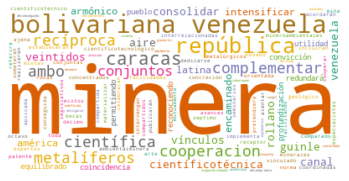

In [48]:
wc.generate(texto)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Ahora si vemos palabras más relevantes.

# Unificamos

Normalizamos de nuevo todos los documentos, para que aplique el nuevo listado de stop words.

In [49]:
df_corpus["TEXTO_NORM"] = df_corpus["TEXTO"].apply(lambda x: normalize_texto(x))

In [50]:
df_corpus["CANT_PALABRAS"] = df_corpus["TEXTO_NORM"].apply(lambda x: len(x))
df_corpus.head()

,ID,FILE,TEXTO,TEXTO_NORM,CANT_PALABRAS
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...,minera caracas bolivariana venezuela científic...,1471
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...,suprema generan expropiación lavalle aire aire,46
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...,tesorería remanentes remanentes tesoreria rema...,146
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...,simplificado pequeños reintegros restitución r...,239
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...,hogar circuito componente interinstitucional r...,1213


In [65]:
df_corpus["TOP_10"] = df_corpus["ID"].apply(lambda x: ' '.join(list(get_top10(x).keys())))

In [66]:
print(f'Los documentos tienen una media de {int(df_corpus["CANT_PALABRAS"].mean())} palabras.' )
df_corpus['CANT_PALABRAS'].describe()

Los documentos tienen una media de 1420 palabras.


count     2500.000000
mean      1420.120800
std       3803.981806
min          0.000000
25%        116.750000
50%        443.000000
75%       1124.000000
max      67079.000000
Name: CANT_PALABRAS, dtype: float64

In [67]:
df_corpus.head()

,ID,FILE,TEXTO,TEXTO_NORM,CANT_PALABRAS,TOP_10
0,0,../Datos/Infoleg/100016.txt,ACUERDOS\nLey 25.939\nApruébase el Acuerdo Sob...,minera caracas bolivariana venezuela científic...,1471,cooperación venezuela minera bolivariana parte...
1,1,../Datos/Infoleg/100025.txt,MINISTERIO DE ECONOMIA Y PRODUCCION\nDecisión ...,suprema generan expropiación lavalle aire aire,46,anexas planillas judicial lavalle expropiación...
2,2,../Datos/Infoleg/100026.txt,Secretaría de Hacienda\nPRESUPUESTO\nResolució...,tesorería remanentes remanentes tesoreria rema...,146,remanentes presupuesto hacienda ejercicio deci...
3,3,../Datos/Infoleg/100027.txt,Ministerio de Economía y Producción\nREGIMEN S...,simplificado pequeños reintegros restitución r...,239,reintegros restitución magnética parciales pro...
4,4,../Datos/Infoleg/100028.txt,Secretaría de Empleo\nPROGRAMA JEFES DE HOGAR\...,hogar circuito componente interinstitucional r...,1213,curso beneficiarios componente hogar empleo uo...


Genero una nube de palabras con las incluidas en la columna TOP_10

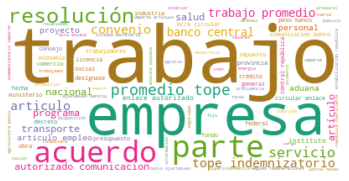

In [70]:
wc.generate(' '.join(df_corpus['TOP_10']))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Observamos palabras como *trabajo*, *empresa*, *salud*, *tope indemnizatorio*

In [83]:
df_corpus.query('TOP_10.str.contains("trabajo")')['TOP_10'].count()

471

In [84]:
df_corpus.query('TOP_10.str.contains("minera")')['TOP_10'].count()

9

In [85]:
df_corpus.query('TOP_10.str.contains("salud")')['TOP_10'].count()

78

In [82]:
df_corpus.query('TOP_10.str.contains("indemnizatorio")')['TOP_10'].count()

142